In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn import inspection
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor as Sk_GradientBoostingRegressor

In [2]:
class DecisionNode():
    """
    Building units of decision trees
    """
    def __init__(self, threshold = None, left_branch = None,
                 right_branch = None, feature_i = None, value = None,
                 criterion_reduction = None, criterion_total = None,
                 n_samples = None):
        # Threshold is the value of the feature that splits the data
        self.threshold = threshold
        # Feature index
        self.feature_i = feature_i
        # Value of the predictions
        self.value = value
        # criterion reduction amount 
        self.criterion_reduction = criterion_reduction 
        # total criterion calculation
        self.criterion_total = criterion_total
        # number of samples at node         
        self.n_samples = n_samples  
        # Links to the left and right subtrees from the current node                   
        self.left_branch = left_branch
        self.right_branch = right_branch
      
class Helper():
    """
    Summary:
    A helper function containing various calculation-based and general functions
    """
    def divide_on_feature(self,X, feature, threshold, number_of_features):
        """
        Summary:
        Function to divide the sample into left and right subsamples based on the threshold

        Args:
            X : n x (d+1) Matrix with x and y values 
            feature: Current feature index that is being split
            threshold: Threshold value dictating the split
            number_of_features: Total features in the X matrix 

        Returns:
            tuple: Left and right subsamples of X and y
        """
        
        # Defining the split functions
        split_func = lambda sample: sample[feature] >= threshold 

        # Getting the left and right splits 
        Xy_left = np.array([val for val in X if split_func(val)])
        Xy_right = np.array([val for val in X if not split_func(val)])

        # If the splits result in no value we ignore the threshold
        if len(Xy_left) == 0 or len(Xy_right) == 0:
                return None
        else:
            # Getting the left and right X & y values
            X_left = Xy_left[:,:number_of_features]
            y_left = Xy_left[:, number_of_features:]

            X_right = Xy_right[:,:number_of_features]
            y_right = Xy_right[:, number_of_features:]

            return X_left, X_right, y_left, y_right

    def calculate_variance(self, X):
        """ 
        Summary:
        Return the variance of the features in dataset X 
        
        Args:
            X: n x d data matrix 
            
        Returns:
            Variance of the current split
        """
        
        mean = np.ones(np.shape(X)) * X.mean(0)
        n_samples = np.shape(X)[0]
        variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))

        return variance

class DecisionTree():
    """
  Summary:
  Class containing all functions for implementing a decision tree 
  """

    def __init__(self, max_depth, min_samples, loss_threshold, min_impurity, loss = 'l2'):
        # 0 - constant model, 1 - one split, ...
        self.max_depth = max_depth 
        # eg. l2 for sum of squares any differentiable loss works
        self.loss = loss 
        # min number of observations in the resulting split
        self.min_samples = min_samples 
        # min loss to split
        self.loss_threshold = loss_threshold 
        # getting min impurity per tree
        self.min_impurity = min_impurity
        # getting helper object
        self.helper = Helper()

    def _tree_builder(self, X, y, current_depth = 0):
        """
        Summary:
        Recursive function to build the tree

        Args:
        X (np.array): n x d Data matrix 
        y (np.array): n x 1 response vector
        current_depth (int) : Stores the current depth of the recursive function iteration

        Returns:
        DecisionNode(): Root node of the decision tree generated
        """

        # Initialize maximum impurity for current depth
        max_impurity = 0

        # Storing feature information
        feature_data = None 

        # Storing branch data
        best_split = None 

        # Check if y is a 2-d array, if not then make it into one
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=1)

        # Combining X and y into one data matrix
        Xy = np.concatenate((X, y), axis = 1)

        # Getting number of observations and features
        number_of_samples, number_of_features = X.shape

        # Check if number of samples is less than the minimum or depth exceeds max depth
        if current_depth <= self.max_depth and number_of_samples >= self.min_samples:

            # Parsing through every feature
            for feature in range(number_of_features):
            # Getting specific feature values
                X_feature = np.expand_dims(X[:, feature], axis= 1)

                # We are checking for an appropriate threshold by parsing through
                # all unique values in the current sample to find the most optimal split
                threshold_vals = np.unique(X_feature)

                for threshold in threshold_vals:
                # Splitting the data based on one threshold value
                    vals = self.helper.divide_on_feature(Xy, feature, threshold, number_of_features)

                    if vals == None:
                        continue
                    else:
                        X_left, X_right, y_left, y_right = vals
                        # Calculating threshold based on current split                                                                 
                        impurity, criterion_total = self._impurity_func(y, y_left, y_right)

                        # Calculate number of samples at node i
                        n_samples = Xy.shape[0]

                        # Check if current impurity is greater than maximum
                        if impurity > max_impurity:
                            max_impurity = impurity
                            feature_data = {
                            "feature_idx": feature,
                            "threshold": threshold,
                            "criterion_reduction": impurity,
                            "criterion_total": criterion_total,
                            "n_samples": n_samples
                            }

                            best_split = {
                                        "left" :  X_left, 
                                        "right" :  X_right, 
                                        "y_left" : y_left, 
                                        "y_right" :  y_right
                                        }
                

        if max_impurity > self.min_impurity:
            # Building the left and right subtrees 
            left_branch = self._tree_builder(
            best_split["left"],
            best_split["y_left"],
            current_depth = current_depth + 1
            )

            right_branch = self._tree_builder(
            best_split["right"],
            best_split["y_right"],
            current_depth = current_depth + 1
            )
        
            return DecisionNode(feature_i=feature_data["feature_idx"],
                                threshold=feature_data["threshold"],
                                criterion_reduction=feature_data["criterion_reduction"],
                                criterion_total=feature_data["criterion_total"],
                                n_samples=feature_data["n_samples"],
                                left_branch=left_branch, right_branch=right_branch)
        # Once the left and right subtrees are generated, we calculate the value 
        # at the current node
        leaf_value = self._leaf_value_calculation(y)

        # get summary statistics for the leaf node
        n_samples = len(y)
        var_total = self.helper.calculate_variance(y)
        
        #print(leaf_value)
        return DecisionNode(value=leaf_value,
                            n_samples=n_samples,
                            criterion_total=var_total)
        
    def fit(self, X, y, loss=None):
        """
        Summary:
        Function to fit the current dataset

        Args:
        X (np.array): n x d Data matrix 
        y (np.array): n x 1 response vector
        loss (__func__): Defines the loss function to store the overall training loss
        """

        # Creating the tree and getting the root value of the tree
        self.root = self._tree_builder(X, y)

        # Calculating the loss
        self.loss = None

    def make_prediction(self, X, tree=None):
        """
        Summary:
        Make a prediction of each sample based on the value of the leafs

        Args:
        X (np.array or pd.DataFrame)
        tree: defaults to None
        
        
        """
        # if there is no tree, set it to the root
        # if there is a tree, set it to the leaf and return the leaf as predicted value
        if tree is None:
            tree = self.root
        elif tree.value is not None:
            return tree.value
        
        # select an observation from the data
        observation = X[tree.feature_i]
        
        # determine if we follow the left or right branch
        branch = tree.right_branch
        if observation >= tree.threshold or observation == tree.threshold:
            branch = tree.left_branch

        return self.make_prediction(X, tree=branch)

    def predict(self, X):
        """
        Summary:
        Return the predictions for a given set of X values

        Args:
        X (np.array or pd.DataFrame): features that we want to use for predictions
        
        Returns:
        prediction: n x 1 vector of predictions
        """
        predictions = []
        for sample in X:
            pred = self.make_prediction(sample)
            predictions.append(pred)
        return np.array(predictions).flatten()

    def score_r2(self, y_true, y_pred):
        """
        Summary:
        Return the R squared for the model

        Args:
        y_true: vector of true y values
        y_pred: model predictions
        
        Returns:
        int or float: R sqaured value
        """
        ssr = np.sum((y_true - y_pred)**2)
        sst = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - ssr/sst
        return r2

    def score_mse(self, y_true, y_pred):
        """
        Summary:
        Return the mean squared error for the model

        Args:
        y_true: vector of true y values
        y_pred: model predictions
        
        Returns:
        int or float: mean squared error
        """
        mse = np.mean((y_true - y_pred)**2)
        return mse

    def score_mae(self, y_true, y_pred):
        """
        Summary:
        Returns the mean absolute error for the model

        Args:
        y_true: vector of true y values
        y_pred: model predictions
        
        Returns:
        int or float: mean absolute error
        """
        mae = np.mean(np.abs(y_true - y_pred))
        return mae

class RegressionTree(DecisionTree):
    """
  Summary:
  Class that inherits all properties of the decision tree to work as a regression tree
    """
    
    def _calculate_variance_reduction(self, y, y_left, y_right):
        """
        Summary:
        Calculate the variance reduction based on current split

        Args:
        y (np.array):  n x 1 Total response vector
        y_left (np.array): n_left x 1 Response vector for left sub branch
        y_right (np.array): n_right x 1 Response vector for right sub branch
        
        Returns:
        np.float64: variance reduction value
        np.float64: total variance at node i 
        """

        # Getting total variance
        var_total = self.helper.calculate_variance(y)

        # Variance of left subtree
        var_left = self.helper.calculate_variance(y_left)

        # Variance of right subtree
        var_right = self.helper.calculate_variance(y_right)

        # Reduction of variance
        reduction = var_total - ((len(y_left)/len(y)) * var_left + 
                                (len(y_right)/len(y)) * var_right)
        
        #print(reduction)
        # Returning the variance
        return(sum(reduction), sum(var_total))
        
    def _mean_of_y(self, y):
        """
        Summary:
        Mean of current node

        Args:
        y (np.array): n x 1 Response vector
        
        Returns:
        np.float64: Mean of the y vector
        """
        
        # Returning the mean of all values at the current node 
        leaf_val = np.mean(y, axis = 0)

        # Returning the value
        return leaf_val if len(leaf_val) > 1 else leaf_val[0]

    def fit(self, X, y):
        """
        Summary:
        Function to fit a regression tree

        Args:
        X (np.array): n x d Data Matrix
        y (np.array): n x 1 Response vector
        """
        
        # Setting the impurity to variance reduction
        self._impurity_func = self._calculate_variance_reduction

        # Setting the leaf value as mean
        self._leaf_value_calculation = self._mean_of_y

        # Calling fit function in the Decisiontree Class
        super(RegressionTree, self).fit(X, y)
        

class Loss(object):
    """
    Defines the basic loss function for a regression tree
    """

    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0

class SquareLoss(Loss):
    """
    Class describing all the properties of the square loss function
    """
    
    def __init__(self): 
        pass

    def loss(self, y, y_pred):
        """
        Calculates the square loss for a given set of y values and predictions

        Args:
            y (np.array): Actual y values
            y_pred (np.array): Predictions for y values

        Returns:
            float: Square loss
        """
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        """
        Summary:
        Stores the negative gradient for square loss

        Args:
            y (np.array): Actual y values
            y_pred (np.array): Predictions for y values

        Returns:
            np.array: _description_
        """
        return (y - y_pred)

class GradientBoosting(object):
    """
    Summary:
    Super class of GradientBoostingClassifier and GradientBoostinRegressor. 
    Uses a collection of regression trees that trains on predicting the gradient
    of the loss function. 
    
    Args:
    n_estimators: int
        The number of classification trees that are used.
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further. 
    max_depth: int
        The maximum depth of a tree.
    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth):
        
        # Number of trees to be generated
        self.n_estimators = n_estimators
        # Learning rate
        self.learning_rate = learning_rate
        # Minimum samples split
        self.min_samples_split = min_samples_split
        # Minimum impurity per branch
        self.min_impurity = min_impurity
        # Maximum depth of a tree
        self.max_depth = max_depth
        
        # Square loss for regression
        # Log loss for classification
        self.loss = SquareLoss()

        # Initialize regression trees
        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples=self.min_samples_split,
                    min_impurity=min_impurity,
                    loss_threshold=0.001,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        """
        Function to fit a GBR tree

        Args:
            X (np.array): n x d Data Matrix
            y (np.array): n x 1 Response vector
        """
        # Getting the mean of the y values
        self.F0 = np.mean(y)
        
        # Initializing prediction array to calculate the residuals
        y_pred = np.full(np.shape(y), np.mean(y, axis=0))
        for i in range(self.n_estimators):
            # Calculating the gradient
            gradient = self.loss.gradient(y, y_pred)
            # Fitting the tree on the residuals
            self.trees[i].fit(X, gradient)
            # Getting the prediction for the next tree
            update = self.trees[i].predict(X)
            # Update y prediction
            y_pred += np.multiply(self.learning_rate, update)


    def predict(self, X):
        """
        Based on all the trees fit, calculate the predictions

        Args:
            X (np.array): n x d Data Matrix

        Returns:
            np.array : n x 1 Predicted response vector
        """
        y_hat = self.F0 + self.learning_rate * np.sum([t.predict(X) for t in self.trees], axis=0)
        return y_hat
        
class GradientBoostingRegressor(GradientBoosting):
    """
    Class inheriting all the properties of GradientBoosting to demonstrate 
    Gradient Boosting regressor

    Args:
        GradientBoosting (object): Super class of GradientBoostingRegressor
    """
    
    def __init__(self, n_estimators=200, learning_rate=0.1, min_samples_split=2,
                 min_var_red=1e-7, max_depth=3, debug=False):
        """
        Function to initialize the GradientBoostingRegressor class
        """ 
        super(GradientBoostingRegressor, self).__init__(n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            min_samples_split=min_samples_split, 
            min_impurity=min_var_red,
            max_depth=max_depth)
        


In [3]:
"""
#############################################
REAL DATA STUDY
#############################################
"""

# Seeing the effect of different parameters on the performance of the model
# Initializing the dataset
diabetes = load_diabetes()

# subset the data
X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Learning rate

In [4]:
# a. Learning rate

# Initializing the learning rate
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4]

# Initializing SkLearn and From Scratch implementations MSEs
mse_lists_og_train1 = []
mse_lists_sk_train1 = []
mse_lists_og_test1 = []
mse_lists_sk_test1 = []

# Parsing through the learning rates
for rate in learning_rates:
    print(rate)
    # our gbm
    gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=rate, min_samples_split=2, max_depth=3)
    gbr.fit(X_train, y_train)

    mse_lists_og_test1.append(np.mean((y_test - gbr.predict(X_test)) ** 2))
    mse_lists_og_train1.append(np.mean((y_train - gbr.predict(X_train)) ** 2))
    
    # sklearn gbm
    sk_gbr = Sk_GradientBoostingRegressor(learning_rate=rate, n_estimators=50, min_samples_split=2, max_depth=3)
    sk_gbr.fit(X_train, y_train)

    mse_lists_sk_test1.append(np.mean((y_test - sk_gbr.predict(X_test)) ** 2))
    mse_lists_sk_train1.append(np.mean((y_train - sk_gbr.predict(X_train)) ** 2))

0.0001
0.001
0.01
0.1
0.2
0.3
0.4


In [5]:
print(mse_lists_og_test1)
print(mse_lists_og_train1)
print(mse_lists_sk_test1)
print(mse_lists_sk_train1)

[5409.489889113844, 5208.031644106694, 3911.318246797932, 3104.0765010393634, 3282.4165003291632, 3720.9149514210876, 4064.2486858942293]
[6111.486523990191, 5795.690664140716, 3687.8747471283255, 716.1737543929527, 296.8504403726817, 129.4461699903872, 51.917059165549894]
[5411.755462302275, 5225.517741629717, 3931.758714231581, 2948.3640548770986, 2981.927901965438, 3584.412614909222, 3509.4369621907053]
[6116.143118950463, 5839.996045663178, 3998.9848293677564, 1351.5932182772015, 873.8364256059308, 474.2890915459399, 297.85651991427017]


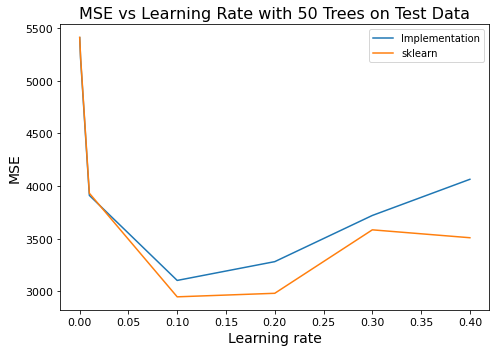

In [7]:
plt.figure(figsize=(7,5))
plt.plot(learning_rates, mse_lists_og_test1, label='Implementation')
plt.plot(learning_rates, mse_lists_sk_test1, label='sklearn')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Learning rate", size=14)
plt.ylabel("MSE", size=14)
plt.title("MSE vs Learning Rate with 50 Trees on Test Data", size=16)
plt.tight_layout()
plt.legend()
plt.savefig('learning_rate_test.jpg')
plt.show()

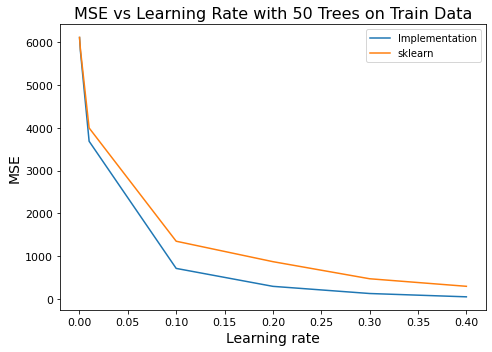

In [8]:
plt.figure(figsize=(7,5))
plt.plot(learning_rates, mse_lists_og_train1, label='Implementation')
plt.plot(learning_rates, mse_lists_sk_train1, label='sklearn')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Learning rate", size=14)
plt.ylabel("MSE", size=14)
plt.title("MSE vs Learning Rate with 50 Trees on Train Data", size=16)
plt.tight_layout()
plt.legend()
plt.savefig('learning_rate_train.jpg')
plt.show()

### Number of trees

In [9]:
# b. Number of trees

# Initializing the number of trees
n_trees = [1, 10, 20, 50, 100, 200]

# Initializing SkLearn and from scratch implementations MSEs
mse_lists_og_train2 = []
mse_lists_sk_train2 = []
mse_lists_og_test2 = []
mse_lists_sk_test2 = []

# Parsing through the number of trees
for tree in n_trees:
    print(tree)
    gbr = GradientBoostingRegressor(n_estimators=tree, learning_rate=0.1, min_samples_split=2, max_depth=3)
    gbr.fit(X_train, y_train)

    mse_lists_og_test2.append(np.mean((y_test - gbr.predict(X_test)) ** 2))
    mse_lists_og_train2.append(np.mean((y_train - gbr.predict(X_train)) ** 2))

    sk_gbr = Sk_GradientBoostingRegressor(learning_rate=0.1, n_estimators=tree, min_samples_split=2, max_depth=3)
    sk_gbr.fit(X_train, y_train)

    mse_lists_sk_test2.append(np.mean((y_test - sk_gbr.predict(X_test)) ** 2))
    mse_lists_sk_train2.append(np.mean((y_train - sk_gbr.predict(X_train)) ** 2))

1
10
20
50
100
200


In [10]:
print(mse_lists_og_test2)
print(mse_lists_og_train2)
print(mse_lists_sk_test2)
print(mse_lists_sk_train2)

[4990.086990699986, 3329.801662269658, 2942.142696262424, 3104.0765010393634, 3285.549967549426, 3519.9084796966076]
[5445.704479896104, 2511.134348285523, 1527.8499521771178, 716.1737543929527, 284.6453685087171, 60.575161337305836]
[5032.344547562313, 3250.578099352225, 2899.183580261812, 2955.082091885209, 3059.064835400119, 3297.115118265321]
[5534.618474153377, 2958.6889942080197, 2106.92867037684, 1351.5932182772015, 876.78315944595, 356.4697275722434]


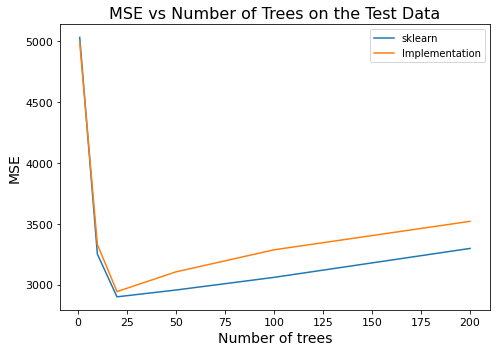

In [11]:
plt.figure(figsize=(7,5))
plt.plot(n_trees, mse_lists_sk_test2, label='sklearn')
plt.plot(n_trees, mse_lists_og_test2, label='Implementation')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel( "Number of trees", size=14)
plt.ylabel("MSE", size=14)
plt.title("MSE vs Number of Trees on the Test Data", size=16)
plt.tight_layout()
plt.legend()
plt.savefig('num_trees_test.jpg')
plt.show()

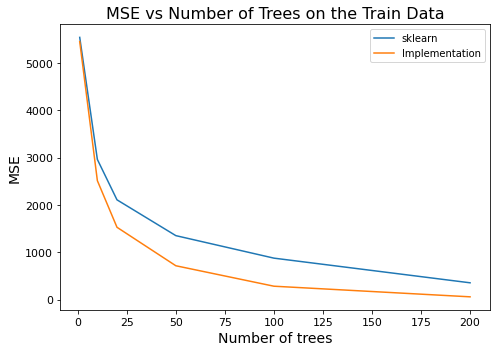

In [12]:
plt.figure(figsize=(7,5))
plt.plot(n_trees, mse_lists_sk_train2, label='sklearn')
plt.plot(n_trees, mse_lists_og_train2, label='Implementation')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel( "Number of trees", size=14)
plt.ylabel("MSE", size=14)
plt.title("MSE vs Number of Trees on the Train Data", size=16)
plt.tight_layout()
plt.legend()
plt.savefig('num_trees_train.jpg')
plt.show()